# Contents and requrements in this notebook

In [3]:
import pandas as pd

tinytest_df=pd.read_csv('data/tiny_test.csv')
print(tinytest_df.head(38))

    sentence_id        words   tags
0             0          The      O
1             0  programmers      O
2             0         from      O
3             0    Barcelona  B-geo
4             0        might      O
5             0        write      O
6             0            a      O
7             0     sentence      O
8             0      without      O
9             0            a      O
10            0        spell      O
11            0      checker      O
12            0            .      O
13            1          The      O
14            1  programmers      O
15            1         from      O
16            1   Barchelona  B-geo
17            1       cannot      O
18            1        write      O
19            1            a      O
20            1     sentence      O
21            1      without      O
22            1            a      O
23            1        spell      O
24            1      checker      O
25            1            .      O
26            2         Jack

# Part Alana Zoloeva

# Part Ralitsa Dimitrova

## 0. A baseline perceptrone similar to the one used for POS tagging in lectures (but using .csv)
Only used for comparing the results in new models

The Bseline perceptrone trained with 5 epochs and no extra features added:

The train and test accuracy INCLUDING Os are: Train: 0.962 Test: 0.876

We'll load it to get the accuracy on the tiny test dataset:

With Os it is SP -  Accuracy Tiny Test: 0.644 

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import skseq
from skseq.sequences.sequence import Sequence
import skseq.sequences.structured_perceptron as spc
from utils.structured_perceptrone_utils import NewPostagCorpus

In [10]:
#load corpus:
corpus = NewPostagCorpus()
train_seq = corpus.read_sequence_list_csv("data/train_data_ner.csv")
word_dict = train_seq.x_dict
tag_dict  = train_seq.y_dict

print(len(train_seq))
print(len(word_dict))
print(len(tag_dict))

corpus1 = NewPostagCorpus()
corpus1.word_dict = corpus.word_dict
corpus1.tag_dict = corpus.tag_dict
tiny_test_seq = corpus1.read_sequence_list_csv("data/tiny_test.csv", update_dict=False)

corpus2 = NewPostagCorpus()
corpus2.word_dict = corpus.word_dict
corpus2.tag_dict = corpus.tag_dict
test_seq = corpus2.read_sequence_list_csv("data/test_data_ner.csv", update_dict=False)

feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq)
feature_mapper.build_features()

38364
31965
17


In [112]:
sp = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper)
print(sp.parameters) #should be empty now
sp.load_model(dir="fitted_models/perceptron_baseline")

[0. 0. 0. ... 0. 0. 0.]


In [113]:
sp.parameters.sum() # is the same as when checking in the train

100124.2

In [114]:
sp.state_labels

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-geo': 5,
 'B-per': 6,
 'I-per': 7,
 'I-org': 8,
 'B-art': 9,
 'I-art': 10,
 'I-tim': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

In [56]:
#now test with the tiny test and print accuracy:

In [58]:
# AGAIN, using the same corpus for the tiny test as the train, so they share the words, and no unknown words exist (unrealisitc)
tiny_test_seq_nn = corpus.read_sequence_list_csv("data/tiny_test.csv", update_dict=True)
pred_tiny_test = sp.viterbi_decode_corpus(tiny_test_seq_nn)

In [ ]:
# IMPORTANT! Using the proposed way in lectures, so that there are no unnown words, althouh this is unlikely in 
# a real scenario: (For the imporvements of the perceptrone for NER I have put handling for unknown words)
test_seq_nn = corpus.read_sequence_list_csv("data/test_data_ner.csv", update_dict=True)

pred_test = sp.viterbi_decode_corpus(test_seq_nn)

In [ ]:
pred_train = sp.viterbi_decode_corpus(train_seq)

In [126]:
from utils.structured_perceptrone_utils import *

In [61]:
eval_tiny_test = evaluate_corpus_non_O(tiny_test_seq.seq_list, pred_tiny_test)
eval_test = evaluate_corpus_non_O(ftest_seq_nn.seq_list, pred_test)
eval_train = evaluate_corpus_non_O(train_seq.seq_list, pred_train)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_1, eval_test_1, eval_tiny_test_1))

SP -  Accuracy Tiny Test: 0.644


## 1. Load the first test with custom emission features:

The train and test accuracies (ignoring Os): SP -  Accuracy WITHOUT Os Train: 0.819 Test:   1 Tiny Test: 0.828

In [164]:
from utils.structured_perceptrone_utils import NERFeatures

In [115]:
feature_mapper_ner = NERFeatures(train_seq)
feature_mapper_ner.build_features()

In [116]:
sp_1 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner)
print(sp_1.parameters) #should be empty now
sp_1.load_model(dir="fitted_models/perceptron_1_")
print(sp_1.parameters)

[0. 0. 0. ... 0. 0. 0.]
[29.4  3.   5.  ...  1.   0.   0. ]


In [117]:
for i, seq in enumerate(tiny_test_seq.seq_list):
    if len(seq.x) == 0:
        print(f"Empty feature sequence at index {i}")

In [118]:
for i, seq in enumerate(test_seq.seq_list):
    if len(seq.x) == 0:
        print(f"Empty feature sequence at index {i}")

Empty feature sequence at index 13539
Empty feature sequence at index 29617
Empty feature sequence at index 29859


In [11]:
fixed_tiny_test_seq_list = []

for seq in tiny_test_seq.seq_list:
    if len(seq.x) == 0:
        # Replace empty input with one UNK word and dummy label
        dummy_x = ["<UNK>"]
        dummy_y = [0]  # Arbitrary, won't be used in viterbi
        new_seq = Sequence(x=dummy_x, y=dummy_y)
        fixed_tiny_test_seq_list.append(new_seq)
    else:
        fixed_tiny_test_seq_list.append(seq)

from skseq.sequences.sequence_list import SequenceList  

fixed_tiny_test_dataset = SequenceList(x_dict=tiny_test_seq.x_dict, y_dict=tiny_test_seq.y_dict)
fixed_tiny_test_dataset.seq_list = fixed_tiny_test_seq_list

In [14]:
fixed_test_seq_list = []

for seq in test_seq.seq_list:
    if len(seq.x) == 0:
        # Replace empty input with one UNK word and dummy label
        dummy_x = ["<UNK>"]
        dummy_y = [0]  # Arbitrary, won't be used in viterbi
        new_seq = Sequence(x=dummy_x, y=dummy_y)
        fixed_test_seq_list.append(new_seq)
    else:
        fixed_test_seq_list.append(seq)

fixed_test_dataset = SequenceList(x_dict=test_seq.x_dict, y_dict=test_seq.y_dict)
fixed_test_dataset.seq_list = fixed_test_seq_list

In [121]:
print(len(fixed_tiny_test_seq_list))
print(len(fixed_test_seq_list))

13
38364


In [122]:
print(len(tiny_test_seq))
print(len(test_seq))

13
38364


In [123]:
pred_train_1 = sp_1.viterbi_decode_corpus(train_seq)

In [124]:
pred_tiny_test_1 = sp_1.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [125]:
pred_test_1 = sp_1.viterbi_decode_corpus(fixed_test_dataset)

In [104]:
eval_tiny_test_1 = evaluate_corpus(fixed_tiny_test_dataset.seq_list, pred_tiny_test_1)
eval_test_1 = evaluate_corpus(fixed_test_dataset.seq_list, pred_test_1)
eval_train_1 = evaluate_corpus(train_seq.seq_list, pred_train_1)

print("SP -  Accuracy with Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_1, eval_test_1, eval_tiny_test_1))

SP -  Accuracy with Os Train: 0.962 Test:   1 Tiny Test: 0.963


In [78]:
# Take the accuracy of the tags which are not predicted as O:

In [108]:
eval_tiny_test_1 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_1)
eval_test_1 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_1)
eval_train_1 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_1)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_1, eval_test_1, eval_tiny_test_1))

SP -  Accuracy WITHOUT Os Train: 0.819 Test:   1 Tiny Test: 0.828


In [85]:
# and now get the accuracy of O tags, because I'm currious:

In [127]:
eval_tiny_test_1 = evaluate_O_accuracy(fixed_tiny_test_dataset.seq_list, pred_tiny_test_1)
eval_test_1 = evaluate_O_accuracy(fixed_test_dataset.seq_list, pred_test_1)
eval_train_1 = evaluate_O_accuracy(train_seq.seq_list, pred_train_1)

print("SP -  Accuracy ONLY Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_1, eval_test_1, eval_tiny_test_1))

SP -  Accuracy ONLY Os Train: 0.988 Test:   1 Tiny Test: 1.000


### w1/t1 predictions of the Tiny test:

In [129]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_1)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/1 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/0 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/0 1/0 9/0 141/1 660/5 1/5 3572/5 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/6 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


In [130]:
print("And the real w1/t1,...\n")
print(fixed_tiny_test_dataset.seq_list)

And the real w1/t1,...

[203/0 2672/0 18/0 14394/1 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/7 2044/0 7/0 21/0 , 2342/6 6/7 2044/0 7/0 1165/1 21/0 , 670/6 2622/7 13/0 9925/6 2254/7 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/0 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/0 1/0 9/0 141/1 660/5 1/5 3572/5 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix and F1 score

In [22]:
from utils.structured_perceptrone_utils import *

#### On the Train set:

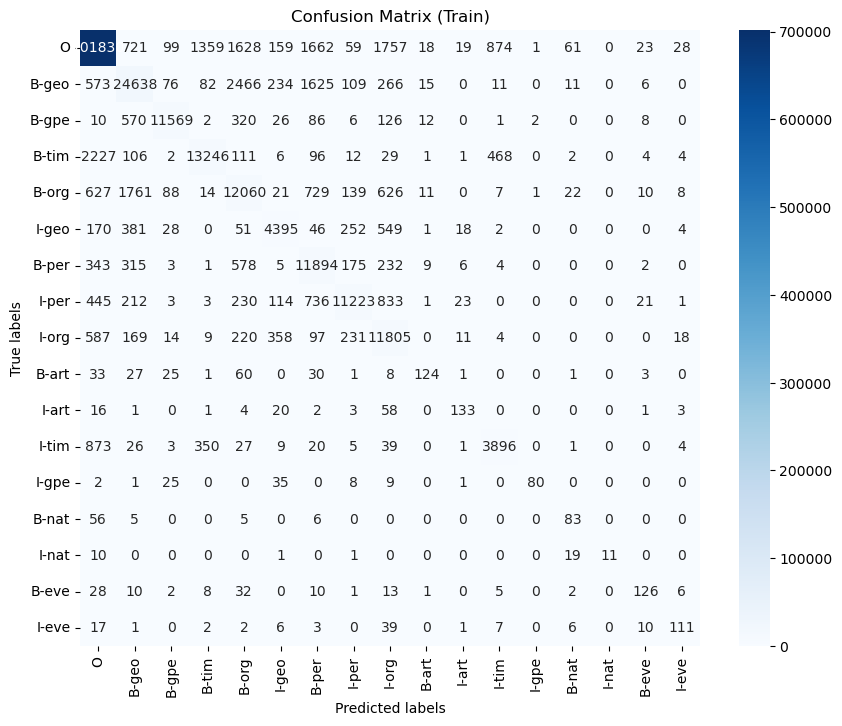

Train Weighted F1-score: 0.9627
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    710298
       B-geo       0.85      0.82      0.83     30112
       B-gpe       0.97      0.91      0.94     12738
       B-tim       0.88      0.81      0.84     16315
       B-org       0.68      0.75      0.71     16124
       I-geo       0.82      0.75      0.78      5897
       B-per       0.70      0.88      0.78     13567
       I-per       0.92      0.81      0.86     13845
       I-org       0.72      0.87      0.79     13523
       B-art       0.64      0.39      0.49       314
       I-art       0.62      0.55      0.58       242
       I-tim       0.74      0.74      0.74      5254
       I-gpe       0.95      0.50      0.65       161
       B-nat       0.40      0.54      0.46       155
       I-nat       1.00      0.26      0.42        42
       B-eve       0.59      0.52      0.55       244
       I-eve       0.59      0.54      0.57      

In [166]:
cm_train, f1_train = evaluate_predictions(train_seq.seq_list, pred_train_1, tag_dict, set_name="Train")

#### On the Test set:

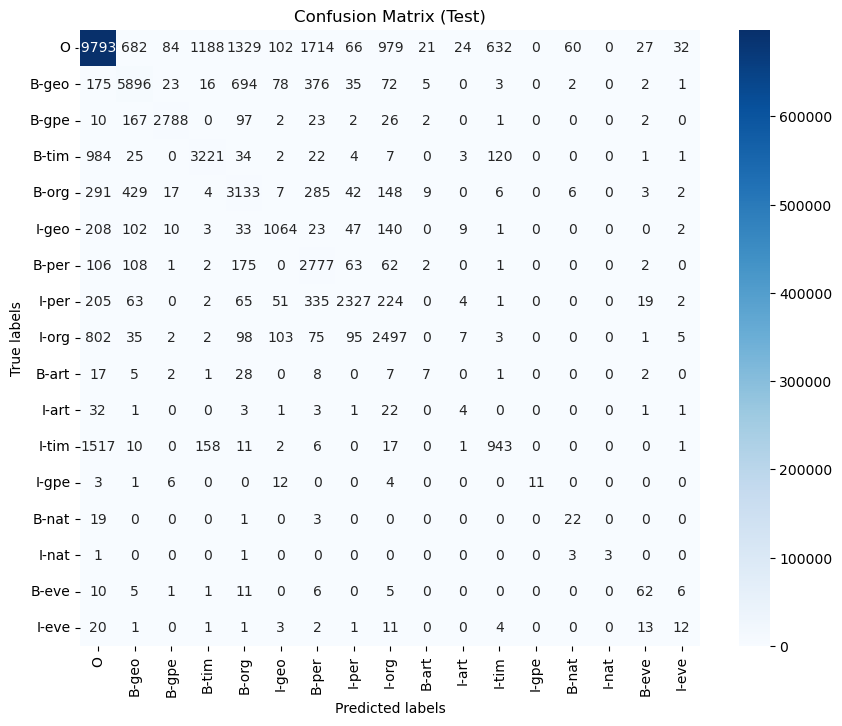

Test Weighted F1-score: 0.9782
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    704874
       B-geo       0.78      0.80      0.79      7378
       B-gpe       0.95      0.89      0.92      3120
       B-tim       0.70      0.73      0.71      4424
       B-org       0.55      0.71      0.62      4382
       I-geo       0.75      0.65      0.69      1642
       B-per       0.49      0.84      0.62      3299
       I-per       0.87      0.71      0.78      3298
       I-org       0.59      0.67      0.63      3725
       B-art       0.15      0.09      0.11        78
       I-art       0.08      0.06      0.07        69
       I-tim       0.55      0.35      0.43      2666
       I-gpe       1.00      0.30      0.46        37
       B-nat       0.24      0.49      0.32        45
       I-nat       1.00      0.38      0.55         8
       B-eve       0.46      0.58      0.51       107
       I-eve       0.18      0.17      0.18       

In [167]:
cm_test, f1_test = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_1, tag_dict, set_name="Test")

## 2. Evaluate Second perceptron with Handcrafted features
SP -  Accuracy WITHOUT Os Train: 0.831 Test:   1 Tiny Test: 0.690

In [172]:
from utils.structured_perceptrone_utils import *

In [171]:
feature_mapper_ner_2 = NERFeatures_2(train_seq)
feature_mapper_ner_2.build_features()

In [154]:
sp_2 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner_2)
print(sp_2.parameters) #should be empty now
sp_2.load_model(dir="fitted_models/perceptron_2_")
print(sp_2.parameters)

[0. 0. 0. ... 0. 0. 0.]
[23.2  0.6  2.8 ...  0.   0.   0. ]


In [155]:
pred_train_2 = sp_2.viterbi_decode_corpus(train_seq)

In [156]:
pred_tiny_test_2 = sp_2.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [157]:
pred_test_2 = sp_2.viterbi_decode_corpus(fixed_test_dataset)

In [158]:
eval_tiny_test_2 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_2)
eval_test_2 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_2)
eval_train_2 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_2)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_2, eval_test_2, eval_tiny_test_2))

SP -  Accuracy WITHOUT Os Train: 0.831 Test:   1 Tiny Test: 0.690


### Tiny Test w1/t1,...

In [159]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_2)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/6 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/0 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/0 1/0 9/0 141/4 660/8 1/8 3572/8 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


In [160]:
print("And the real w1/t1,...\n")
print(fixed_tiny_test_dataset.seq_list)

And the real w1/t1,...

[203/0 2672/0 18/0 14394/1 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/7 2044/0 7/0 21/0 , 2342/6 6/7 2044/0 7/0 1165/1 21/0 , 670/6 2622/7 13/0 9925/6 2254/7 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/0 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/0 1/0 9/0 141/1 660/5 1/5 3572/5 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix F1 score

#### Train set:

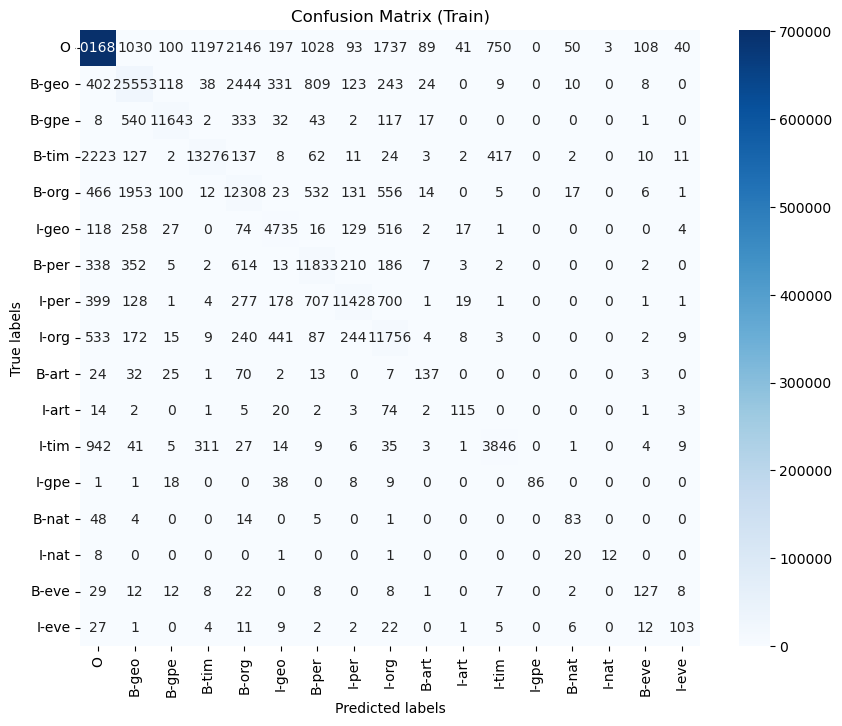

Train Weighted F1-score: 0.9645
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    710298
       B-geo       0.85      0.85      0.85     30112
       B-gpe       0.96      0.91      0.94     12738
       B-tim       0.89      0.81      0.85     16315
       B-org       0.66      0.76      0.71     16124
       I-geo       0.78      0.80      0.79      5897
       B-per       0.78      0.87      0.82     13567
       I-per       0.92      0.83      0.87     13845
       I-org       0.74      0.87      0.80     13523
       B-art       0.45      0.44      0.44       314
       I-art       0.56      0.48      0.51       242
       I-tim       0.76      0.73      0.75      5254
       I-gpe       1.00      0.53      0.70       161
       B-nat       0.43      0.54      0.48       155
       I-nat       0.80      0.29      0.42        42
       B-eve       0.45      0.52      0.48       244
       I-eve       0.54      0.50      0.52      

In [162]:
cm_train_2, f1_train_2 = evaluate_predictions(train_seq.seq_list, pred_train_2, tag_dict, set_name="Train")

#### Test set:

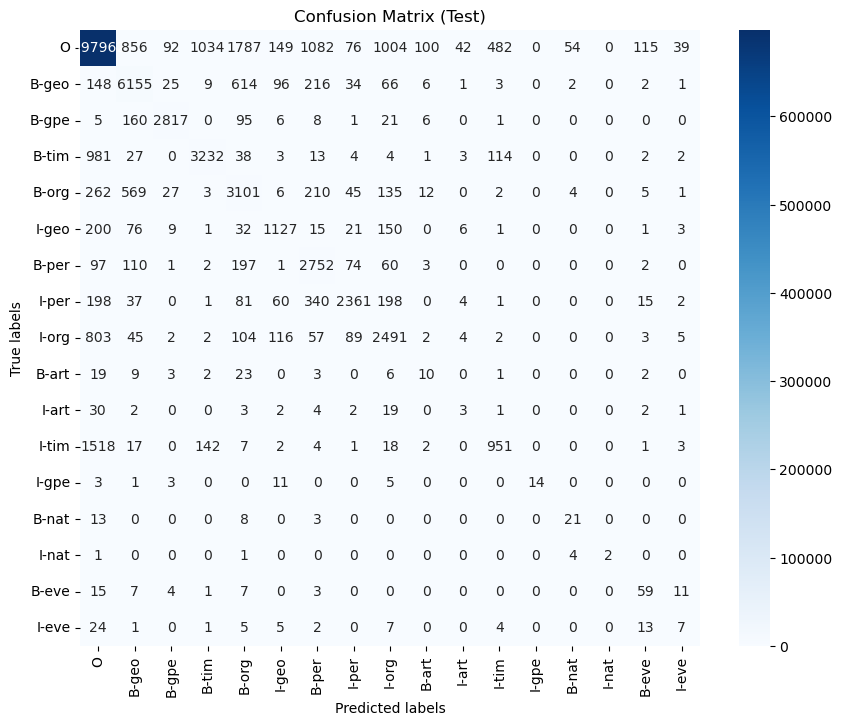

Test Weighted F1-score: 0.9787
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    704874
       B-geo       0.76      0.83      0.80      7378
       B-gpe       0.94      0.90      0.92      3120
       B-tim       0.73      0.73      0.73      4424
       B-org       0.51      0.71      0.59      4382
       I-geo       0.71      0.69      0.70      1642
       B-per       0.58      0.83      0.69      3299
       I-per       0.87      0.72      0.79      3298
       I-org       0.60      0.67      0.63      3725
       B-art       0.07      0.13      0.09        78
       I-art       0.05      0.04      0.05        69
       I-tim       0.61      0.36      0.45      2666
       I-gpe       1.00      0.38      0.55        37
       B-nat       0.25      0.47      0.32        45
       I-nat       1.00      0.25      0.40         8
       B-eve       0.27      0.55      0.36       107
       I-eve       0.09      0.10      0.10       

In [163]:
cm_test_2, f1_test_2 = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_2, tag_dict, set_name="Test")

## 3. Test 3rd perceptron with custom features

SP -  Accuracy WITHOUT Os Train: 0.842 Test:   1 Tiny Test: 0.552

In [15]:
from utils.structured_perceptrone_utils import NERFeatures_3

In [16]:
feature_mapper_ner_3 = NERFeatures_3(train_seq)
feature_mapper_ner_3.build_features()

In [17]:
sp_3 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner_3)
print(sp_3.parameters) #should be empty now
sp_3.load_model(dir="fitted_models/perceptron_3_")
print(sp_3.parameters)

[0. 0. 0. ... 0. 0. 0.]
[25.6  3.6  4.6 ...  1.   0.   0. ]


In [18]:
pred_train_3 = sp_3.viterbi_decode_corpus(train_seq)

In [19]:
pred_tiny_test_3 = sp_3.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [20]:
pred_test_3 = sp_3.viterbi_decode_corpus(fixed_test_dataset)

In [23]:
eval_tiny_test_3 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_3)
eval_test_3 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_3)
eval_train_3 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_3)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_3, eval_test_3, eval_tiny_test_3))

SP -  Accuracy WITHOUT Os Train: 0.842 Test:   1 Tiny Test: 0.552


### Tiny Test w1/t1,....

In [24]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_3)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/4 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/6 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/6 1/0 9/0 141/4 660/8 1/8 3572/8 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/6 1187/7 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/6 1187/7 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix and weighted F1 score

#### Train set:

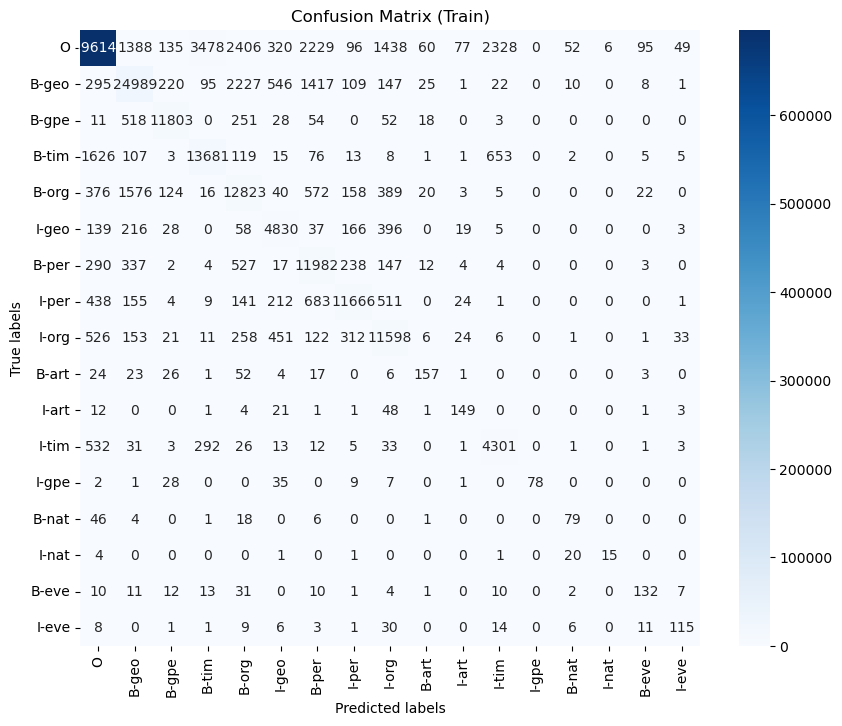

Train Weighted F1-score: 0.9604
              precision    recall  f1-score   support

           O       0.99      0.98      0.99    710298
       B-geo       0.85      0.83      0.84     30112
       B-gpe       0.95      0.93      0.94     12738
       B-tim       0.78      0.84      0.81     16315
       B-org       0.68      0.80      0.73     16124
       I-geo       0.74      0.82      0.78      5897
       B-per       0.70      0.88      0.78     13567
       I-per       0.91      0.84      0.88     13845
       I-org       0.78      0.86      0.82     13523
       B-art       0.52      0.50      0.51       314
       I-art       0.49      0.62      0.54       242
       I-tim       0.58      0.82      0.68      5254
       I-gpe       1.00      0.48      0.65       161
       B-nat       0.46      0.51      0.48       155
       I-nat       0.71      0.36      0.48        42
       B-eve       0.47      0.54      0.50       244
       I-eve       0.52      0.56      0.54      

In [25]:
cm_train_3, f1_train_3 = evaluate_predictions(train_seq.seq_list, pred_train_3, tag_dict, set_name="Train")

#### Test set:

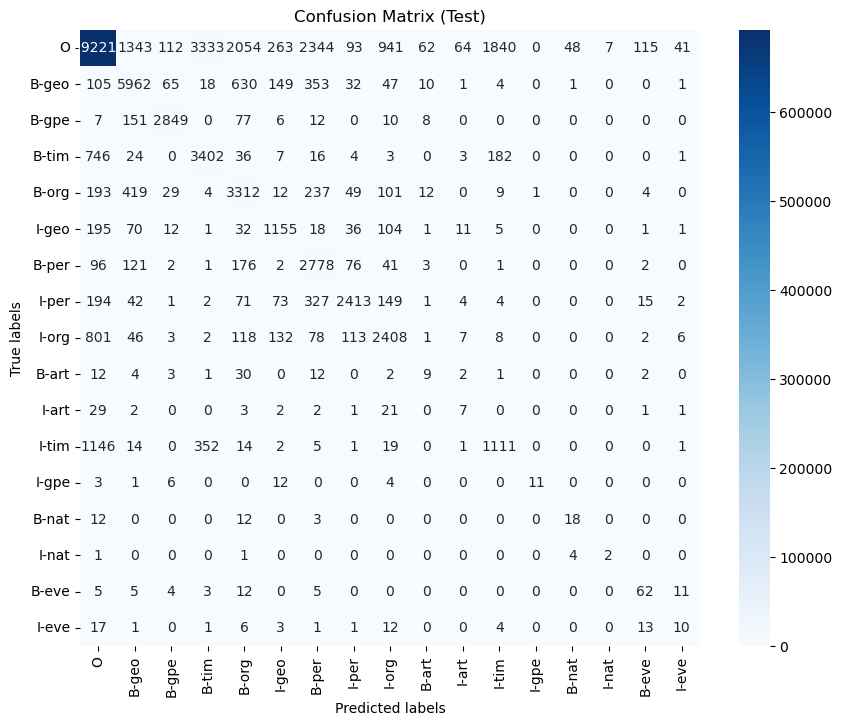

Test Weighted F1-score: 0.9734
              precision    recall  f1-score   support

           O       0.99      0.98      0.99    704874
       B-geo       0.73      0.81      0.77      7378
       B-gpe       0.92      0.91      0.92      3120
       B-tim       0.48      0.77      0.59      4424
       B-org       0.50      0.76      0.60      4382
       I-geo       0.64      0.70      0.67      1642
       B-per       0.45      0.84      0.59      3299
       I-per       0.86      0.73      0.79      3298
       I-org       0.62      0.65      0.63      3725
       B-art       0.08      0.12      0.10        78
       I-art       0.07      0.10      0.08        69
       I-tim       0.35      0.42      0.38      2666
       I-gpe       0.92      0.30      0.45        37
       B-nat       0.25      0.40      0.31        45
       I-nat       0.22      0.25      0.24         8
       B-eve       0.29      0.58      0.38       107
       I-eve       0.13      0.14      0.14       

In [26]:
cm_test_3, f1_test_3 = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_3, tag_dict, set_name="Test")

## 4. Evaluate 4th model for custom features in NER
SP -  Accuracy WITHOUT Os Train: 0.824 Test:   1 Tiny Test: 0.690

In [27]:
from utils.structured_perceptrone_utils import NERFeatures_4

In [28]:
feature_mapper_ner_4 = NERFeatures_4(train_seq)
feature_mapper_ner_4.build_features()

In [29]:
sp_4 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner_4)
print(sp_4.parameters) #should be empty now
sp_4.load_model(dir="fitted_models/perceptron_4_")
print(sp_4.parameters)

[0. 0. 0. ... 0. 0. 0.]
[30.2  2.   4.  ...  1.   0.   0. ]


In [30]:
pred_train_4 = sp_4.viterbi_decode_corpus(train_seq)

In [31]:
pred_tiny_test_4 = sp_4.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [32]:
pred_test_4 = sp_4.viterbi_decode_corpus(fixed_test_dataset)

In [33]:
eval_tiny_test_4 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_4)
eval_test_4 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_4)
eval_train_4 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_4)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_4, eval_test_4, eval_tiny_test_4))

SP -  Accuracy WITHOUT Os Train: 0.824 Test:   1 Tiny Test: 0.690


### Tiny Test w1/t1,....

In [34]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_4)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/6 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/6 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/6 1/0 9/0 141/4 660/8 1/8 3572/8 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix and weighted F1 score

#### Train set:

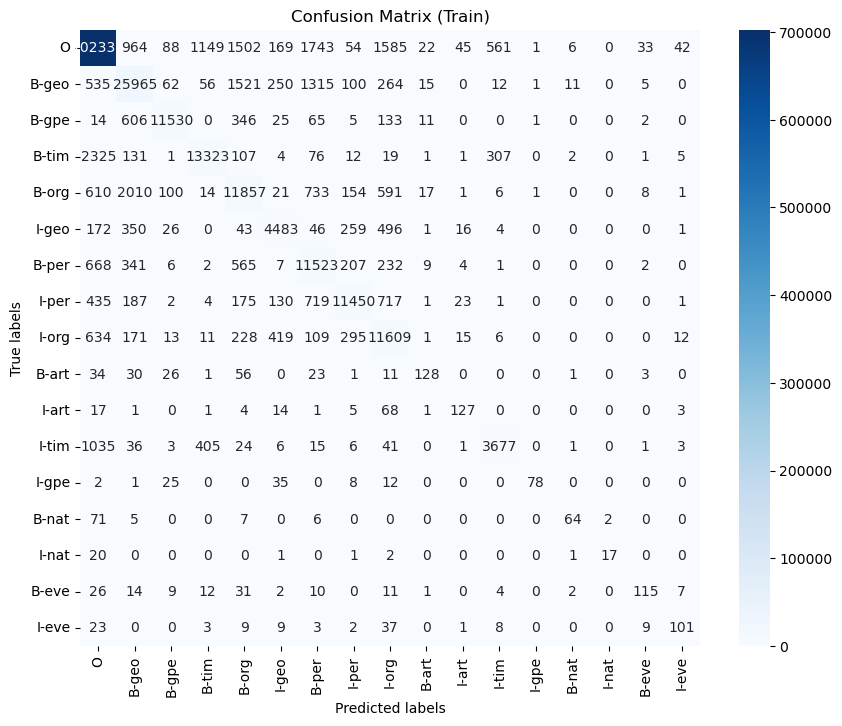

Train Weighted F1-score: 0.9638
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    710298
       B-geo       0.84      0.86      0.85     30112
       B-gpe       0.97      0.91      0.94     12738
       B-tim       0.89      0.82      0.85     16315
       B-org       0.72      0.74      0.73     16124
       I-geo       0.80      0.76      0.78      5897
       B-per       0.70      0.85      0.77     13567
       I-per       0.91      0.83      0.87     13845
       I-org       0.73      0.86      0.79     13523
       B-art       0.62      0.41      0.49       314
       I-art       0.54      0.52      0.53       242
       I-tim       0.80      0.70      0.75      5254
       I-gpe       0.95      0.48      0.64       161
       B-nat       0.73      0.41      0.53       155
       I-nat       0.89      0.40      0.56        42
       B-eve       0.64      0.47      0.54       244
       I-eve       0.57      0.49      0.53      

In [35]:
cm_train_4, f1_train_4 = evaluate_predictions(train_seq.seq_list, pred_train_4, tag_dict, set_name="Train")

#### Test set:

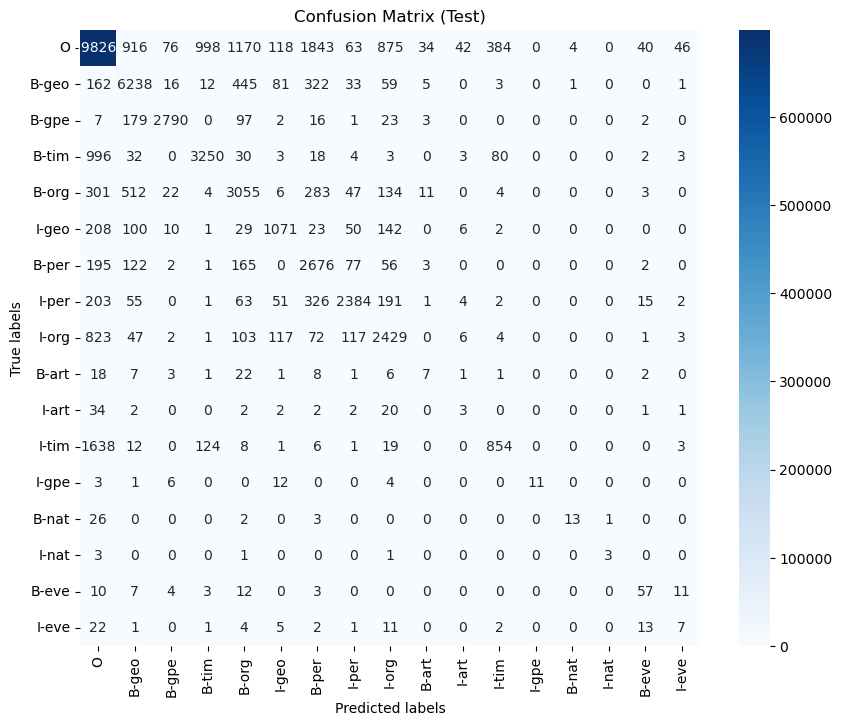

Test Weighted F1-score: 0.9785
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    704874
       B-geo       0.76      0.85      0.80      7378
       B-gpe       0.95      0.89      0.92      3120
       B-tim       0.74      0.73      0.74      4424
       B-org       0.59      0.70      0.64      4382
       I-geo       0.73      0.65      0.69      1642
       B-per       0.48      0.81      0.60      3299
       I-per       0.86      0.72      0.78      3298
       I-org       0.61      0.65      0.63      3725
       B-art       0.11      0.09      0.10        78
       I-art       0.05      0.04      0.04        69
       I-tim       0.64      0.32      0.43      2666
       I-gpe       1.00      0.30      0.46        37
       B-nat       0.72      0.29      0.41        45
       I-nat       0.75      0.38      0.50         8
       B-eve       0.41      0.53      0.47       107
       I-eve       0.09      0.10      0.10       

In [36]:
cm_test_4, f1_test_4 = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_4, tag_dict, set_name="Test")

## 5. Evaluate 5th model for custom features in NER
SP -  Accuracy WITHOUT Os Train: 0.829 Test:   1 Tiny Test: 0.828


In [37]:
from utils.structured_perceptrone_utils import NERFeatures_5

In [38]:
feature_mapper_ner_5 = NERFeatures_5(train_seq)
feature_mapper_ner_5.build_features()

In [40]:
sp_5 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner_5)
print(sp_5.parameters) #should be empty now
sp_5.load_model(dir="fitted_models/perceptron_5_")
print(sp_5.parameters)

[0. 0. 0. ... 0. 0. 0.]
[30.  3.  4. ...  0.  0.  0.]


In [41]:
pred_train_5 = sp_5.viterbi_decode_corpus(train_seq)

In [42]:
pred_tiny_test_5 = sp_5.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [43]:
pred_test_5 = sp_5.viterbi_decode_corpus(fixed_test_dataset)

In [44]:
eval_tiny_test_5 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_5)
eval_test_5 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_5)
eval_train_5 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_5)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_5, eval_test_5, eval_tiny_test_5))

SP -  Accuracy WITHOUT Os Train: 0.829 Test:   1 Tiny Test: 0.828


### Tiny Test w1/t1,....

In [45]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_5)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/6 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/6 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/6 1/0 9/0 141/1 660/5 1/5 3572/5 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix and weighted F1 score

#### Train set:

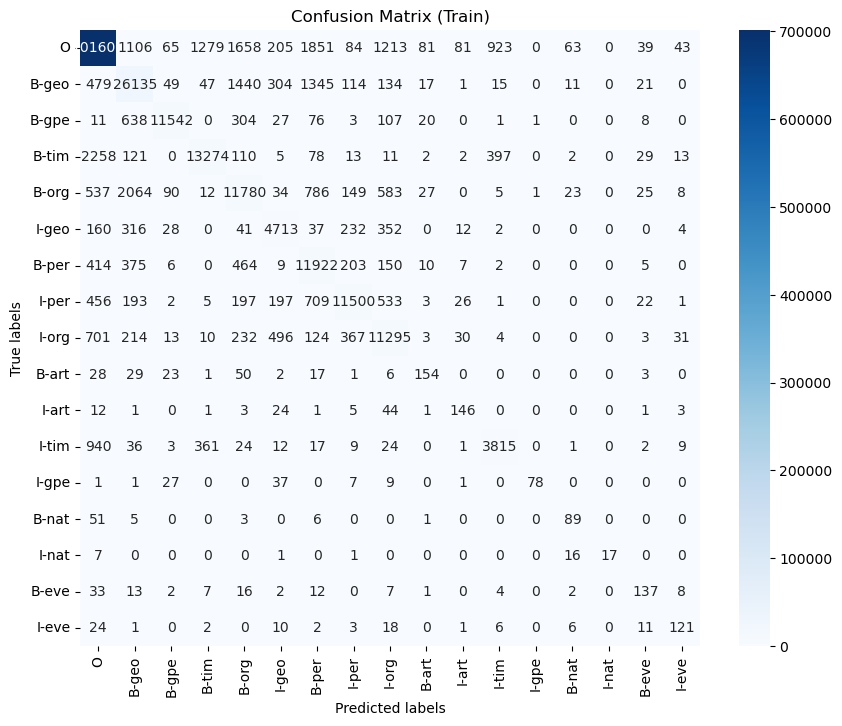

Train Weighted F1-score: 0.9639
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    710298
       B-geo       0.84      0.87      0.85     30112
       B-gpe       0.97      0.91      0.94     12738
       B-tim       0.88      0.81      0.85     16315
       B-org       0.72      0.73      0.73     16124
       I-geo       0.78      0.80      0.79      5897
       B-per       0.70      0.88      0.78     13567
       I-per       0.91      0.83      0.87     13845
       I-org       0.78      0.84      0.81     13523
       B-art       0.48      0.49      0.49       314
       I-art       0.47      0.60      0.53       242
       I-tim       0.74      0.73      0.73      5254
       I-gpe       0.97      0.48      0.65       161
       B-nat       0.42      0.57      0.48       155
       I-nat       1.00      0.40      0.58        42
       B-eve       0.45      0.56      0.50       244
       I-eve       0.50      0.59      0.54      

In [46]:
cm_train_5, f1_train_5 = evaluate_predictions(train_seq.seq_list, pred_train_5, tag_dict, set_name="Train")

#### Test set:

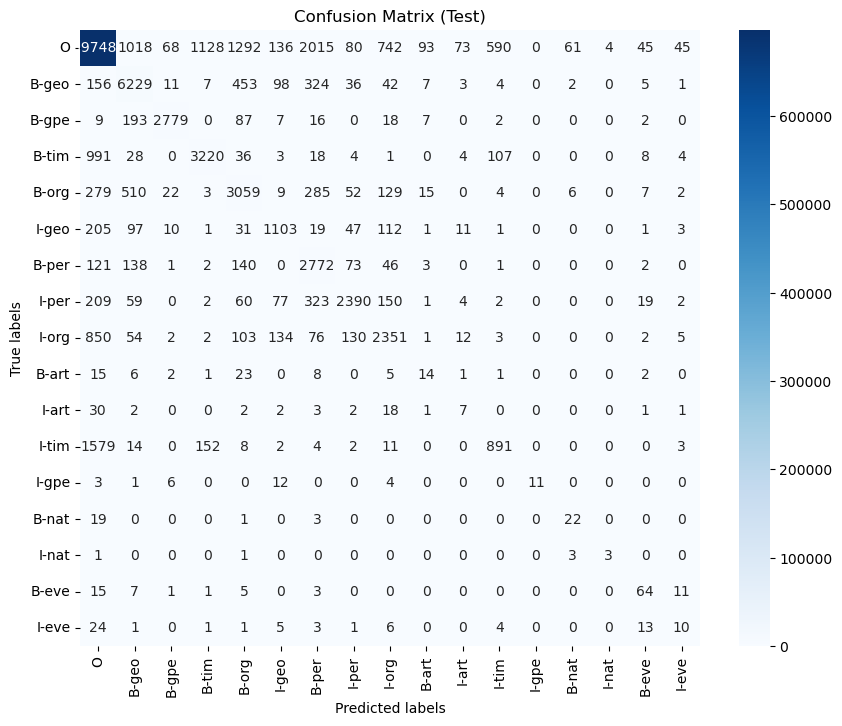

Test Weighted F1-score: 0.9779
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    704874
       B-geo       0.75      0.84      0.79      7378
       B-gpe       0.96      0.89      0.92      3120
       B-tim       0.71      0.73      0.72      4424
       B-org       0.58      0.70      0.63      4382
       I-geo       0.69      0.67      0.68      1642
       B-per       0.47      0.84      0.60      3299
       I-per       0.85      0.72      0.78      3298
       I-org       0.65      0.63      0.64      3725
       B-art       0.10      0.18      0.13        78
       I-art       0.06      0.10      0.08        69
       I-tim       0.55      0.33      0.42      2666
       I-gpe       1.00      0.30      0.46        37
       B-nat       0.23      0.49      0.32        45
       I-nat       0.43      0.38      0.40         8
       B-eve       0.37      0.60      0.46       107
       I-eve       0.11      0.14      0.13       

In [47]:
cm_test_5, f1_test_5 = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_5, tag_dict, set_name="Test")

## 6. Evaluate 6th model for custom features in NER
SP -  Accuracy WITHOUT Os Train: 0.823 Test:   1 Tiny Test: 0.759

In [48]:
from utils.structured_perceptrone_utils import NERFeatures_6

In [49]:
feature_mapper_ner_6 = NERFeatures_6(train_seq)
feature_mapper_ner_6.build_features()

In [50]:
sp_6 = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_ner_6)
print(sp_6.parameters) #should be empty now
sp_6.load_model(dir="fitted_models/perceptron_6_")
print(sp_6.parameters)

[0. 0. 0. ... 0. 0. 0.]
[30.4  3.8  4.6 ...  1.   0.   0. ]


In [51]:
pred_train_6 = sp_6.viterbi_decode_corpus(train_seq)

In [52]:
pred_tiny_test_6 = sp_6.viterbi_decode_corpus(fixed_tiny_test_dataset)

In [53]:
pred_test_6 = sp_6.viterbi_decode_corpus(fixed_test_dataset)

In [54]:
eval_tiny_test_6 = evaluate_corpus_non_O(fixed_tiny_test_dataset.seq_list, pred_tiny_test_6)
eval_test_6 = evaluate_corpus_non_O(fixed_test_dataset.seq_list, pred_test_6)
eval_train_6 = evaluate_corpus_non_O(train_seq.seq_list, pred_train_6)

print("SP -  Accuracy WITHOUT Os Train: %.3f Test: %3.f Tiny Test: %.3f"%( eval_train_6, eval_test_6, eval_tiny_test_6))

SP -  Accuracy WITHOUT Os Train: 0.823 Test:   1 Tiny Test: 0.759


### Tiny Test w1/t1,....

In [55]:
print("predicted w1/t1,... for Tiny Test\n")
print(pred_tiny_test_6)

predicted w1/t1,... for Tiny Test

[203/0 2672/0 18/0 14394/6 7758/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 203/0 2672/0 18/0 6556/0 50/0 2607/0 6903/0 50/0 21/0 , 2342/6 6/1 2044/0 7/0 21/0 , 2342/6 6/1 2044/0 7/0 1165/1 21/0 , 670/6 2622/0 13/0 9925/6 2254/0 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 670/6 994/7 13/0 9925/6 1460/0 804/0 309/4 473/0 626/0 152/0 50/0 2267/0 2225/0 21/0 , 203/0 1747/6 1/0 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 1747/6 1/0 9/0 141/1 660/5 1/0 3572/1 804/0 249/0 1486/0 3796/0 9/0 10/0 21/0 , 203/0 4618/0 1/0 1186/1 1187/5 3164/0 1873/0 2574/0 21/0 , 12845/6 2516/0 80/0 4278/0 7/0 2202/0 7/0 1186/1 1187/5 21/0 , 4291/4 184/0 50/0 1588/0 2225/0 21/0 , 4460/0 7175/0 4824/0 25228/0 13/0 21/0 , 13/0 9749/6 2044/0 7/0 9/0 309/4 455/0 7/0 2996/0 50/0 528/0 2671/0 224/0 137/0 2508/0 7/0 144/1 145/5 21/0 ]


### Confusion matrix and weighted F1 score

#### Train set:

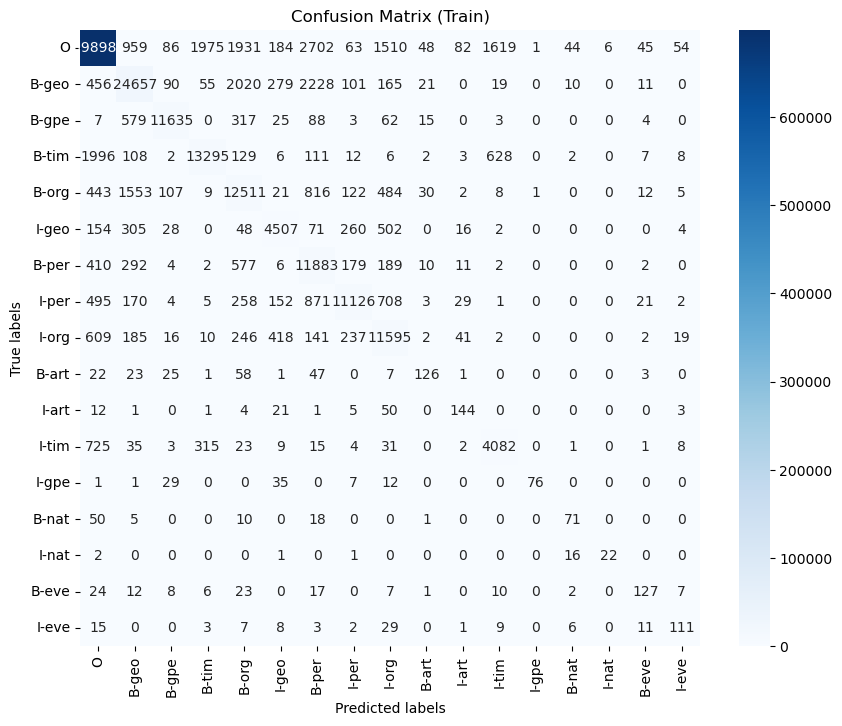

Train Weighted F1-score: 0.9606
              precision    recall  f1-score   support

           O       0.99      0.98      0.99    710298
       B-geo       0.85      0.82      0.84     30112
       B-gpe       0.97      0.91      0.94     12738
       B-tim       0.85      0.81      0.83     16315
       B-org       0.69      0.78      0.73     16124
       I-geo       0.79      0.76      0.78      5897
       B-per       0.63      0.88      0.73     13567
       I-per       0.92      0.80      0.86     13845
       I-org       0.76      0.86      0.80     13523
       B-art       0.49      0.40      0.44       314
       I-art       0.43      0.60      0.50       242
       I-tim       0.64      0.78      0.70      5254
       I-gpe       0.97      0.47      0.64       161
       B-nat       0.47      0.46      0.46       155
       I-nat       0.79      0.52      0.63        42
       B-eve       0.52      0.52      0.52       244
       I-eve       0.50      0.54      0.52      

In [56]:
cm_train_6, f1_train_6 = evaluate_predictions(train_seq.seq_list, pred_train_6, tag_dict, set_name="Train")

#### Test set

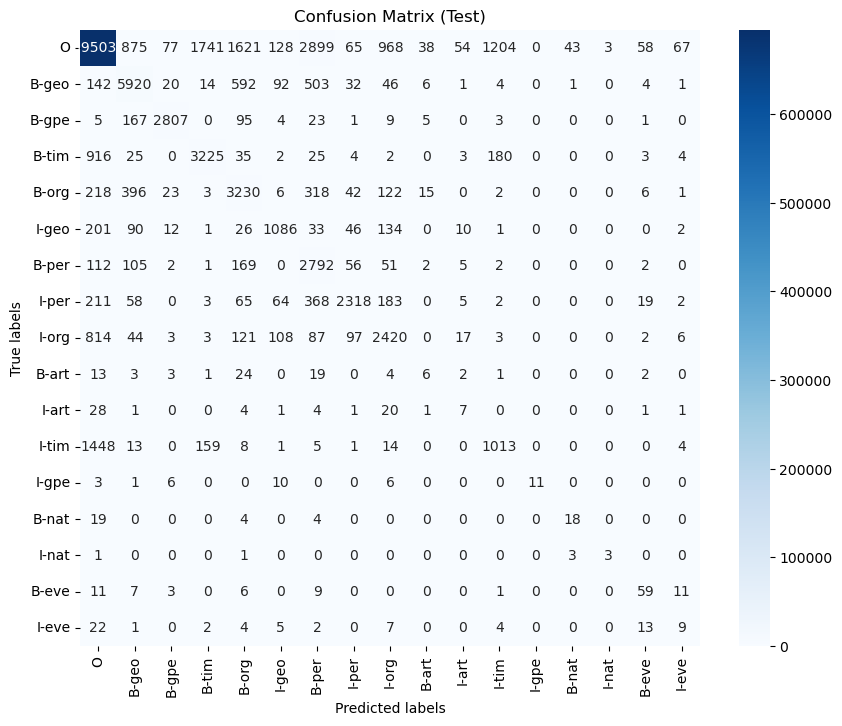

Test Weighted F1-score: 0.9756
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    704874
       B-geo       0.77      0.80      0.78      7378
       B-gpe       0.95      0.90      0.92      3120
       B-tim       0.63      0.73      0.67      4424
       B-org       0.54      0.74      0.62      4382
       I-geo       0.72      0.66      0.69      1642
       B-per       0.39      0.85      0.54      3299
       I-per       0.87      0.70      0.78      3298
       I-org       0.61      0.65      0.63      3725
       B-art       0.08      0.08      0.08        78
       I-art       0.07      0.10      0.08        69
       I-tim       0.42      0.38      0.40      2666
       I-gpe       1.00      0.30      0.46        37
       B-nat       0.28      0.40      0.33        45
       I-nat       0.50      0.38      0.43         8
       B-eve       0.35      0.55      0.43       107
       I-eve       0.08      0.13      0.10       

In [57]:
cm_test_6, f1_test_6 = evaluate_predictions(fixed_test_dataset.seq_list, pred_test_6, tag_dict, set_name="Test")